In [19]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows: Malgun Gothic)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스(-) 깨짐 방지

# 1. 데이터 로드

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = pd.read_csv("./dataset/KRKCN/ca8ed98c-9011-34bd-8d76-97bc262ede93.csv")

# 2. 필요한 컬럼 선택 및 결측치 제거

In [6]:
required_cols = ['LAT', 'LON', 'COG', 'HEADING', 'SPEED']
df = df.dropna(subset=required_cols).copy()

# 3. COG와 HEADING 변화량 계산

In [8]:
df['DELTA_COG'] = df['COG'].diff().abs()
df['DELTA_HEADING'] = df['HEADING'].diff().abs()

# 4. 빙글 도는 조건 설정 (속도 낮고 방향 변화 큰 지점)

In [10]:
condition = (df['SPEED'] < 1.0) & (
    (df['DELTA_COG'] > 30) | (df['DELTA_HEADING'] > 30)
)
df['LOOP'] = condition.astype(int)

# 5. 이상 구간 제거 후 선형 보간

In [12]:
df_cleaned = df[df['LOOP'] == 0].copy()
df_cleaned = df_cleaned.interpolate(method='linear')

C:\Users\user\AppData\Local\Temp\ipykernel_10212\1200463350.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_cleaned = df_cleaned.interpolate(method='linear')


# 6. 시각화: 빙글 항로 vs 정제된 항로 비교

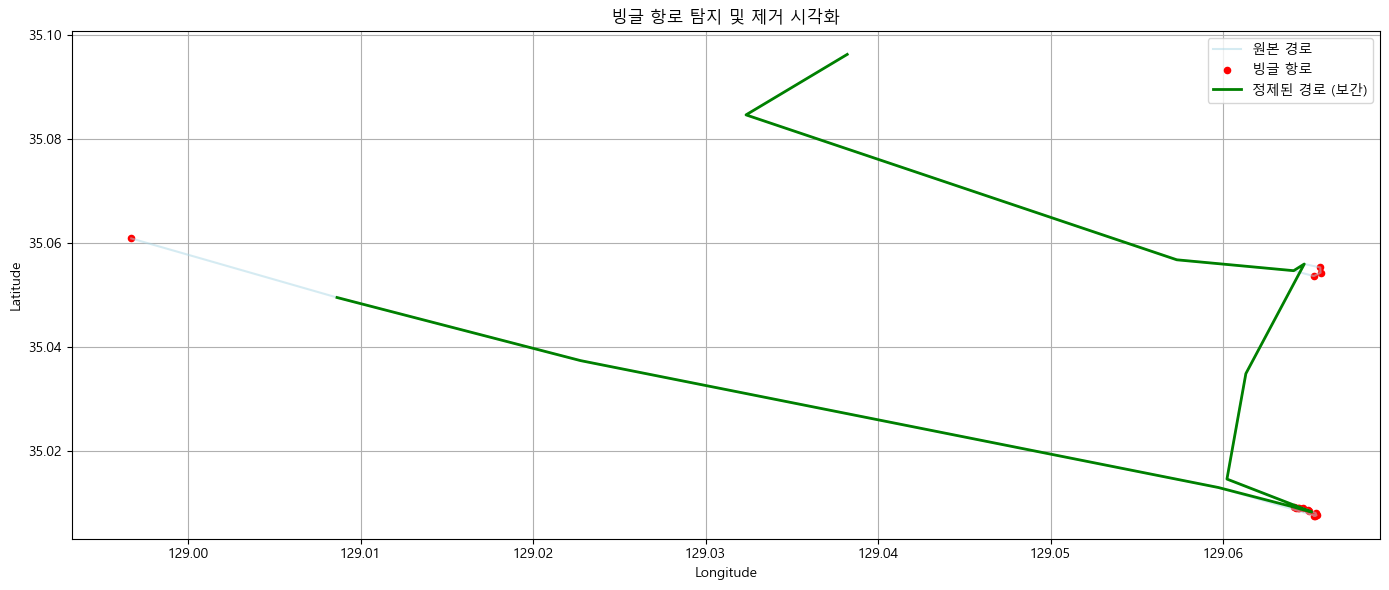

In [21]:
plt.figure(figsize=(14, 6))
# 원본 항로
plt.plot(df['LON'], df['LAT'], label='원본 경로', color='lightblue', alpha=0.5)

# 빙글 회전한 지점 강조
loop_df = df[df['LOOP'] == 1]
plt.scatter(loop_df['LON'], loop_df['LAT'], color='red', label='빙글 항로', s=20)

# 보간된 항로
plt.plot(df_cleaned['LON'], df_cleaned['LAT'], label='정제된 경로 (보간)', color='green', linewidth=2)

plt.title("빙글 항로 탐지 및 제거 시각화")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. folium 지도 위에 결과 표시 (원본 vs 제거 항로)

In [32]:
import folium
from folium.plugins import AntPath

def plot_ship_route_on_map(df_original, df_cleaned, name="Ship Route"):
    # 중심 좌표 (중앙값 기준)
    center_lat = df_original['LAT'].mean()
    center_lon = df_original['LON'].mean()

    # 지도 생성
    m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

    # 원본 경로 선
    folium.PolyLine(
        locations=list(zip(df_original['LAT'], df_original['LON'])),
        color='blue', weight=2, tooltip='원본 경로'
    ).add_to(m)

    # 빙글 지점 빨간 마커
    loop_df = df_original[df_original['LOOP'] == 1]
    for _, row in loop_df.iterrows():
        folium.CircleMarker(
            location=(row['LAT'], row['LON']),
            radius=3,
            color='red',
            fill=True,
            fill_opacity=0.7,
            popup='빙글 지점'
        ).add_to(m)

    # 정제 경로 선 (보간 결과)
    folium.PolyLine(
        locations=list(zip(df_cleaned['LAT'], df_cleaned['LON'])),
        color='green', weight=2, tooltip='보간 경로'
    ).add_to(m)

    return m

# 사용 예시
m = plot_ship_route_on_map(df, df_cleaned)
display(m)

# 보간하기

In [38]:
import pandas as pd

# CSV 파일 로드
file_path = './dataset1/KRPUS_KRINC/3a290d96-dae5-392a-bf11-0891c0e4ba7c.csv'
df = pd.read_csv(file_path)

# Timestamp를 datetime으로 변환
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

# Timestamp를 인덱스로 설정
df.set_index('TIMESTAMP', inplace=True)

# 결과 저장 리스트
resampled_list = []

# 선박 ID 기준 그룹화 후 10분 리샘플링 + 선형 보간
for vessel_id, group in df.groupby('VSL_ID'):
    # 10분 간격으로 리샘플링 (첫 번째 값 기준)
    resampled = group.resample('10T').first()

    # vessel_ID 유지
    resampled['VSL_ID'] = vessel_id

    # 선형 보간 (선택적으로 'spline'으로 변경 가능)
    resampled = resampled.interpolate(method='linear')

    # 결과 리스트에 추가
    resampled_list.append(resampled)

# 모든 선박 데이터 병합 및 인덱스 초기화
resampled_df = pd.concat(resampled_list).reset_index()

# 원본 파일에 덮어쓰기
resampled_df.to_csv(file_path, index=False)

print(f"선형 보간 후 원본 파일에 덮어쓰기 완료! 파일 경로: {file_path}")

선형 보간 후 원본 파일에 덮어쓰기 완료! 파일 경로: ./dataset1/KRPUS_KRINC/3a290d96-dae5-392a-bf11-0891c0e4ba7c.csv


C:\Users\user\AppData\Local\Temp\ipykernel_60144\3169143987.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = group.resample('10T').first()
C:\Users\user\AppData\Local\Temp\ipykernel_60144\3169143987.py:25: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  resampled = resampled.interpolate(method='linear')


In [36]:
import pandas as pd
import folium

# CSV 파일 로드
df = pd.read_csv('./dataset1/KRPUS_KRINC/3a290d96-dae5-392a-bf11-0891c0e4ba7c.csv')  # 파일 경로는 상황에 맞게 조정

# 특정 선박 ID 선택 (예: 첫 번째 선박)
first_vessel_id = df['VSL_ID'].unique()[0]
vessel_data = df[df['VSL_ID'] == first_vessel_id]

# 중심 좌표 계산
center_lat = vessel_data['LAT'].mean()
center_lon = vessel_data['LON'].mean()

# 지도 생성
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# 선박 경로 좌표 추출
coordinates = list(zip(vessel_data['LAT'], vessel_data['LON']))

# 경로 선 추가
folium.PolyLine(locations=coordinates, color='blue', weight=2.5).add_to(m)

# 시작점 마커
folium.Marker(
    location=coordinates[0],
    popup='Start',
    icon=folium.Icon(color='green')
).add_to(m)

# 끝점 마커
folium.Marker(
    location=coordinates[-1],
    popup='End',
    icon=folium.Icon(color='red')
).add_to(m)

# 결과 저장 또는 출력
m.save('vessel_path_map.html')  # 웹 브라우저에서 열 수 있음
m  # Jupyter Notebook 등에서는 이렇게 바로 출력됨
